# Toxic Comment Classification

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Naive-Bayes-Classifier" data-toc-modified-id="Naive-Bayes-Classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Naive Bayes Classifier</a></span></li><li><span><a href="#SGD-classifier" data-toc-modified-id="SGD-classifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>SGD Classifier</a></span></li><li><span><a href="#Intermediate-results-and-testing" data-toc-modified-id="Intermediate-results-and-testing-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Intermediate Results and Testing</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li>

## Preparation

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from tqdm.notebook import tqdm
import spacy
from nltk.tokenize import word_tokenize

In [18]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/data/toxic_comments.csv')

In [19]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


The dataset is a collection of comments labeled as toxic or non-toxic. The text needs to be cleaned, which includes converting it to lowercase, removing special characters and extra spaces, tokenizing, lemmatizing, and removing stop words. Additionally, we will remove the column Unnamed: 0 as it duplicates the index and provides no additional information.

In [21]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [22]:
# Loading the spaCy model
nlp = spacy.load("en_core_web_sm")

# Function for cleaning and lemmatizing text using spaCy
def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')

    doc = nlp(sentence)
    lemmatized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    
    stop_words = set(stopwords.words('english'))
    lemmatized = [word for word in lemmatized if word not in stop_words]

    cleaned_sentence = " ".join(lemmatized)
    return cleaned_sentence

In [23]:
# Create a separate column to compare text length before and after cleaning
data['original_text_lenth'] = data['text'].apply(lambda x: len(x))

In [24]:
# Apply the cleaning function with a progress bar
tqdm.pandas()
data['text_preprocessed'] = data['text'].progress_apply(preprocessing)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [25]:
data['preprocessing_text_lenth'] = data['text_preprocessed'].apply(lambda x: len(x))

In [26]:
data.head()

,text,toxic,original_text_lenth,text_preprocessed,preprocessing_text_lenth
0,Explanation\nWhy the edits made under my usern...,0,264,explanation \n edit make username hardcore met...,158
1,D'aww! He matches this background colour I'm s...,0,112,daww match background colour I seemingly stuck...,76
2,"Hey man, I'm really not trying to edit war. It...",0,233,hey man I really try edit war guy constantly r...,135
3,"""\nMore\nI can't make any real suggestions on ...",0,622,\n \n I make real suggestion improvement I w...,381
4,"You, sir, are my hero. Any chance you remember...",0,67,sir hero chance remember page,29


In [27]:
# Check for empty strings and remove them
data = data[data['text_preprocessed'].str.strip() != '']
print(f"Number of rows after removing empty texts: {len(data)}")

Number of rows after removing empty texts: 159237


After data preprocessing, the comments were cleaned and normalized, improving their quality and making them more suitable for analysis and modeling. New features were added, such as the length of the original and preprocessed text, which demonstrate that changes were made and the data now looks cleaner.

In [28]:
# Output the number of toxic and non-toxic comments
toxic_counts = data['toxic'].value_counts()
toxic_counts_df = toxic_counts.reset_index()
toxic_counts_df.columns = ['toxic', 'count']
print(toxic_counts_df)

   toxic   count
0      0  143052
1      1   16185


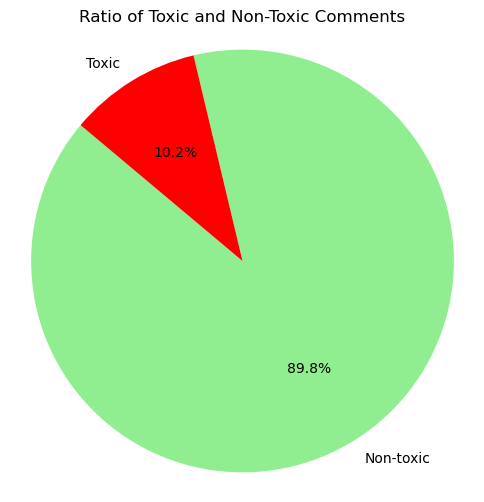

In [29]:
labels = ['Non-toxic', 'Toxic']
colors = ['lightgreen', 'red']

plt.figure(figsize=(6, 6))
plt.pie(toxic_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Ratio of Toxic and Non-Toxic Comments')
plt.axis('equal')
plt.show()

The pie chart shows the ratio of toxic and non-toxic comments in the dataset. From the chart, it is evident that the vast majority of comments — 89.8% — are non-toxic, while 10.2% of comments are classified as toxic.  
  
**Class Imbalance:**
- Non-toxic comments: 89.8%
- Toxic comments: 10.2%  
   
This significant class imbalance suggests the need for applying data balancing techniques when training machine learning models. This may involve using oversampling to increase the number of toxic comments or applying class weighting during model training.

## Training

In [30]:
# Split the data into features
X = data['text_preprocessed']
y = data['toxic']

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [32]:
print(len(X_train)), print(len(X_val)), print(len(X_test));

127389
15924
15924


In [33]:
# Function for training the model and evaluating its performance
def model_function(model_name, X_train, y_train, X_val, y_val):

    # Vectorizing text using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Balancing the data using RandomOverSampler
    ros = RandomOverSampler(sampling_strategy=0.6, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train_vec, y_train)

    # Training the model on balanced data
    model = model_name.fit(X_resampled, y_resampled)
    
    # Making predictions on the validation set
    prediction = model.predict(X_val_vec)
    
    # Calculating the F1 score on the validation set
    f1 = f1_score(y_val, prediction)
    return model, vectorizer, f1

### Logistic Regression

In [34]:
log_model, log_vectorizer, f1_log = model_function(LogisticRegression(random_state=42, solver='saga', max_iter=600,\
                                                                      penalty='l1'),\
                                                   X_train, y_train, X_val, y_val)
print(f'F1 Score for Logistic Regression: {f1_log}')

F1 Score for Logistic Regression: 0.7808460634547592


### Catboost

In [35]:
cat_model, cat_vectorizer, f1_cat = model_function(CatBoostClassifier(learning_rate=0.01, iterations=100,\
                                                                      verbose = 0, random_state = 42),\
                                                   X_train, y_train, X_val, y_val)
print(f'F1 Score for Catboost: {f1_cat}')

F1 Score for Catboost: 0.6386946386946387


### Naive Bayes Classifier

In [36]:
naive_model, naive_vectorizer, f1_naive = model_function(MultinomialNB(), X_train, y_train,\
                                                         X_val, y_val)
print(f'F1 Score for Naive Bayes Classifier: {f1_naive}')

F1 Score for Naive Bayes Classifier: 0.7282913165266106


### SGD Classifier

In [37]:
sgd_model, sgd_vectorizer, f1_sgd = model_function(SGDClassifier(random_state=42, loss='hinge', l1_ratio=0.05,\
                                                                 fit_intercept=True, max_iter=200),\
                                                   X_train, y_train, X_val, y_val)
print(f'F1 Score for SGD Classifier: {f1_sgd}')

F1 Score for SGD Classifier: 0.7805960684844642


### Intermediate Results and Testing

In [38]:
data = {
    'Logistic': f1_log,
    'Catboost': f1_cat,
    'MultinomialNB': f1_naive,
    'SGD': f1_sgd
}

final_df = pd.DataFrame(data, index = [0])
final_df

,Logistic,Catboost,MultinomialNB,SGD
0,0.780846,0.638695,0.728291,0.780596


After conducting experiments with various machine learning models for the toxic comment classification task, the following results were obtained:  
- Stochastic Gradient Descent (SGD) showed the best result with an F1 Score of 0.78, making it the most preferred model for this task.
- Logistic Regression also demonstrated high efficiency with an F1 Score of 0.78, not far behind SGD.
- Multinomial Naive Bayes showed acceptable performance with an F1 Score of 0.73, making it a good candidate for tasks where simplicity and training speed are important.
- CatBoost had the lowest result with an F1 Score of 0.64, which may indicate the need for additional hyperparameter tuning or specific data characteristics affecting its performance.
  
Now, it is necessary to evaluate the model on the test set.

In [39]:
# Select the best model
best_model = sgd_model
best_vectorizer = sgd_vectorizer

In [40]:
# Evaluating the best model on the test set
X_test_vec = best_vectorizer.transform(X_test)
test_predictions = best_model.predict(X_test_vec)
test_f1 = f1_score(y_test, test_predictions)

print(f'F1 SGD Score on the test set: {test_f1}')

F1 SGD Score on the test set: 0.7737765466297323


## Conclusion

In this project, the task of classifying comments as toxic or non-toxic for a new online store service was completed. The main goal was to develop a model capable of effectively detecting toxic comments and sending them for moderation.  
  
**Main stages of the project:**
- Data loading and preprocessing:
    - Text preprocessing was performed, including cleaning the text, removing stop words, and lemmatization.
- Model training and evaluation:
    - Four models were trained and evaluated: Logistic Regression, CatBoost, Multinomial Naive Bayes, and Stochastic Gradient Descent (SGD).
        
**Results on the validation set:**  
- Logistic Regression: F1 Score = 0.78
- CatBoost: F1 Score = 0.64
- Multinomial Naive Bayes: F1 Score = 0.73
- Stochastic Gradient Descent (SGD): F1 Score = 0.78
  
On the test set, the SGD model showed the best result: F1 Score = 0.77

**Recommendations:**  
Based on the analysis and results obtained, it is recommended to use the Stochastic Gradient Descent (SGD) model for classifying comments in the new online store service. This model demonstrated the best F1 Score on both the validation and test sets, allowing for the effective identification of toxic comments and sending them for moderation.